In [1]:
import librosa
import librosa.display
import numpy 
from glob import glob
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import csv
import json

In [3]:
def _writePredictionsTofile(ids, predictions):
    with open("predictions.csv", "w", newline="") as file:
        fieldnames = ["id", "genre"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        size = len(ids)
        for x in range(size):
            writer.writerow({"id": ids[x], "genre": predictions[x]})

In [2]:
def _mapTrainFilesIDToGenre():
    id_genre_dict = dict()
    with open("train.csv", "r") as file:
        csvFile = csv.reader(file)
        for row in csvFile:
            id = row[0]
            id_len = len(id)
            N = 8 - id_len
            id = id.rjust(N + len(id), '0')
            genre = row[1]
            id_genre_dict[id] = genre
    
    if "new_id" in id_genre_dict:

        id_genre_dict.pop("new_id")
    
    return id_genre_dict

In [3]:
def _checkLengthOfAudioFiles(data_dir):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    ls = []
    for i in range (size):
        audio_data, sr = librosa.load(audio_files_arr[i])
        if(len(ls) == 0):
            ls.append(len(audio_data))

        else:
            if ls[0] != len(audio_data):
                print("data have different size")
                break

In [4]:
def _getLowestDuration(data_dir):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    duration_ls = []
    for i in range (size):
        audio_data, sr = librosa.load(audio_files_arr[i])
        duration = len(audio_data) / sr
        duration_ls.append(duration)
    
    return min(duration_ls)


In [5]:
#Visualize an STFT power spectrum using default parameters
def _specshow(dir):
    audio_files_arr = glob(dir + '/*.mp3')
    size = len(audio_files_arr)
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i], duration=29)
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
        ax[0].set(title='Linear-frequency power spectrogram')
        ax[0].label_outer()

In [6]:
#_specshow("small_set")

In [6]:
def _displayMFCC(data_dir,duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)

        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        print("MFCC shape", mfcc.shape)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        

In [7]:
def _displayMFCCPCA(data_dir, duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        scaler = StandardScaler()
        mfcc_rescaled = scaler.fit_transform(mfcc)
        pca = PCA(n_components = 0.999)
        pca.fit(mfcc_rescaled)
        print("PCA components: ",len(pca.components_))
        print("Explained variance: ",pca.explained_variance_)
        reduced_mfcc = pca.transform(mfcc_rescaled)
        print("Reduced Mfcc: ", reduced_mfcc.shape)
        librosa.display.specshow(reduced_mfcc, x_axis='time')
        plt.colorbar()
        plt.title('MFCC PCA')
        plt.tight_layout()

In [8]:
def _getPCAComponentLs(data_dir,duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    ls = []
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        scaler = StandardScaler()
        mfcc_rescaled = scaler.fit_transform(mfcc)
        pca = PCA(n_components = 0.999)
        pca.fit(mfcc_rescaled)
        
        reduced_mfcc = pca.transform(mfcc_rescaled)
        ls.append(len(pca.components_))
    return ls


In [8]:
#Not necessary cuz get lowest duration takes care of this
#_checkLengthOfAudioFiles("train")

In [9]:
#duration_to_read = _getLowestDuration("train")
#29.976598639455784

In [4]:
duration_to_read = 29

In [ ]:
#mfcc_component_ls = _getPCAComponentLs("train",duration_to_read)

In [10]:
def _getPCAComponentCENS(data_dir,duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    ls = []
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
        scaler = StandardScaler()
        cens_rescaled = scaler.fit_transform(chroma_cens)
        pca = PCA(n_components = 0.999)
        pca.fit(cens_rescaled)
        
        reduced_cens = pca.transform(cens_rescaled)
        ls.append(len(pca.components_))
    return ls

In [ ]:
#cens_component_ls = _getPCAComponentCENS("train", duration_to_read)

In [ ]:
#_displayMFCC("small_set",duration_to_read)


In [ ]:
#_displayMFCCPCA("small_set", duration_to_read)

In [5]:
MFCC_COMPONENTS = 17
CENS_COMPONENTS = 11

In [34]:
def _saveMFCCToJSon(data_dir,duration, id_class_dict):
  jason_data = {
      "mfccs": [],
      "labels": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[6:14]           
    y, sr = librosa.load(audio_path,duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    scaler = StandardScaler()
    mfcc_rescaled = scaler.fit_transform(mfcc)
    pca = PCA(n_components = MFCC_COMPONENTS)
    pca.fit(mfcc_rescaled)
    reduced_mfcc = pca.transform(mfcc_rescaled)

    jason_data["mfccs"].append(reduced_mfcc.tolist())
    genre = id_class_dict[id]
    jason_data["labels"].append(genre)

  with open('mfcc.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [13]:
def _saveCENSToJson(data_dir,duration, id_class_dict):
  jason_data = {
      "cens": [],
      "labels": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[6:14]           
    y, sr = librosa.load(audio_path,duration=duration)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    scaler = StandardScaler()
    chroma_rescaled = scaler.fit_transform(chroma)
    pca = PCA(n_components = CENS_COMPONENTS)
    pca.fit(chroma_rescaled)
    cens = pca.transform(chroma_rescaled)

    jason_data["cens"].append(cens.tolist())
    genre = id_class_dict[id]
    jason_data["labels"].append(genre)

  with open('cens.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [ ]:
def _saveTestMFCCToJSon(data_dir,duration):
  jason_data = {
      "mfccs": [],
      "ids": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[5:13]           
    print(audio_path)
    print(id)
    y, sr = librosa.load(audio_path,duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    scaler = StandardScaler()
    mfcc_rescaled = scaler.fit_transform(mfcc)
    pca = PCA(n_components = MFCC_COMPONENTS)
    pca.fit(mfcc_rescaled)
    reduced_mfcc = pca.transform(mfcc_rescaled)

    jason_data["mfccs"].append(reduced_mfcc.tolist())
    jason_data["ids"].append(id)

  with open('mfcc_test.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [ ]:
def _saveTestCENSToJson(data_dir,duration):
  jason_data = {
      "cens": [],
      "ids": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[5:13]           
    y, sr = librosa.load(audio_path,duration=duration)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    scaler = StandardScaler()
    chroma_rescaled = scaler.fit_transform(chroma)
    pca = PCA(n_components = CENS_COMPONENTS)
    pca.fit(chroma_rescaled)
    cens = pca.transform(chroma_rescaled)

    jason_data["cens"].append(cens.tolist())
    jason_data["ids"].append(id)

  with open('cens_test.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [5]:
id_class_dict = _mapTrainFilesIDToGenre()

In [ ]:
# _saveMFCCToJSon("train",duration_to_read, id_class_dict)

In [ ]:
# _saveCENSToJson("train",duration_to_read, id_class_dict)

In [ ]:
def _getCENSTestData():
  with open('./cens_test.json', "r") as file:
    data = json.load(file)
  
  mfccs = numpy.array(data["cens"])
  ids = data["ids"]
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,ids

In [ ]:
def _getCENSTrainingData():
  with open('./cens.json', "r") as file:
    data = json.load(file)
  
  mfccs = numpy.array(data["cens"])
  y_train = numpy.array(data["labels"])
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,y_train

In [ ]:
def _getMFCCTrainingData():
  with open('./mfcc.json', "r") as file:
    data = json.load(file)
  
  mfccs = numpy.array(data["mfccs"])
  y_train = numpy.array(data["labels"])
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,y_train

In [ ]:
def _getMFCCTestData():
  with open('./mfcc_test.json', "r") as file:
    data = json.load(file)
  
  mfccs = numpy.array(data["mfccs"])
  ids = data["id"]
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,ids

In [ ]:
#_saveTestMFCCToJSon("test",duration_to_read)
#_saveTestCENSToJson("test",duration_to_read)

# Part 1: Data Processing and Representation

## 1.1 Representing data as a time series 

/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


(-1.0, 1.0)

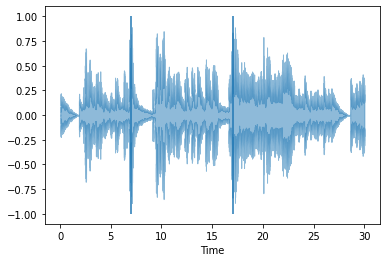

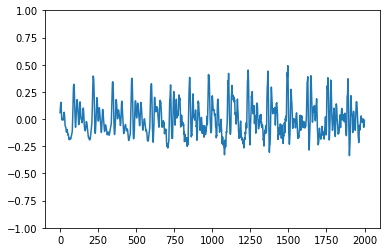

In [2]:
# Returns audio time series as a numpy array 
# default rate(sr) or 22KHZ
# Sample rate (sr) = the number of samples of audio carried per second, measured in Hz or kHz.
sample_path = './small_set/00907483.mp3'
x, sr = librosa.load(sample_path)
# print(type(x), type(sr))
# print(x.shape, sr)

start, end = 7, 17

# Compute and display signal time series 
# From: https://nbviewer.org/github/mdeff/fma/blob/outputs/usage.ipynb
# waveshow documentation: http://librosa.org/doc/0.8.1/generated/librosa.display.waveshow.html#librosa.display.waveshow 
librosa.display.waveshow(x, sr, alpha=0.5)
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1))

## 1.2 Representing data as images (spectrograms)

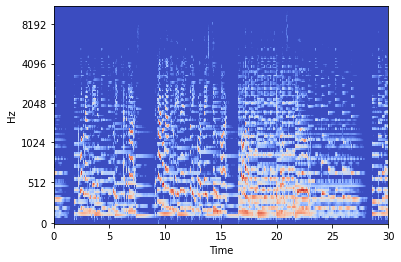

In [13]:
# Compute and display spectrogram
# From: https://nbviewer.org/github/mdeff/fma/blob/outputs/usage.ipynb

stft = numpy.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

## 1.3 Representing data [...]

I will work on this part! -Mari

# Part 2: Classification

Load training data as X_train and y_train

Load test data as X_test and y_test

## 2.1 SVM

In [30]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import cross_val_predict

In [6]:
X_train_mfcc,Y_train_mfcc = _getMFCCTrainingData()
X_test_mfcc, mfcc_ids = _getMFCCTestData()

In [7]:
# SVC Linear from SciKit Learn
def _getLinearSVCPredictions():
   svm_linear = skl.svm.LinearSVC(C = 0.01, dual = False, penalty = 'l1', tol = 1e-3, max_iter=3000)
   kf = KFold(n_splits=5, shuffle=True)
   scores = cross_val_score(svm_linear, X_train_mfcc, Y_train_mfcc, cv=kf)
   print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()*100))
   cv_preds = []
   for train_index, test_index in kf.split(X_train_mfcc):
      X_train, X_test = X_train_mfcc[train_index], X_train_mfcc[test_index]
      y_train, y_test = Y_train_mfcc[train_index], Y_train_mfcc[test_index]
      svm_linear.fit(X_train,y_train)
      predictions = cross_val_predict(svm_linear, X_test, y_test, cv=kf)
      cv_preds.append(predictions)
   
   lsvc_predictions = numpy.array(cv_preds).flatten()
   linear_svc_cm = confusion_matrix(Y_train_mfcc,lsvc_predictions)
   print(linear_svc_cm)

   svm_linear.fit(X_train_mfcc,Y_train_mfcc)
   predictions = svm_linear.predict(X_test_mfcc)
   return predictions

In [8]:
linear_svc_preds = _getLinearSVCPredictions()

44.42 accuracy with a standard deviation of 2.12
[[ 95  39  66  50  81  69]
 [ 91  29  49  61  81  89]
 [101  68  29  57  73  72]
 [ 90  40  44  58  72  96]
 [ 80  48  30  63  83  96]
 [ 81  44  64  36  74 101]]


In [14]:
def _getSVCPredictions():
   svc = svm.SVC(decision_function_shape='ovo')
   kf = KFold(n_splits=5, shuffle=True)
   scores = cross_val_score(svc, X_train_mfcc, Y_train_mfcc, cv=kf)
   print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()*100))
   cv_preds = []
   for train_index, test_index in kf.split(X_train_mfcc):
      X_train, X_test = X_train_mfcc[train_index], X_train_mfcc[test_index]
      y_train, y_test = Y_train_mfcc[train_index], Y_train_mfcc[test_index]
      svc.fit(X_train,y_train)
      predictions = cross_val_predict(svc, X_test, y_test, cv=kf)
      cv_preds.append(predictions)
   
   cv_predictions = numpy.array(cv_preds).flatten()
   svc_cm = confusion_matrix(Y_train_mfcc,cv_predictions)
   print(svc_cm)

   svc.fit(X_train_mfcc,Y_train_mfcc)
   predictions = svc.predict(X_test_mfcc)

   return predictions

In [15]:
svc_preds = _getSVCPredictions()
#print(len(svc_preds))

46.75 accuracy with a standard deviation of 1.17
[[ 84  36 138  60  68  14]
 [ 73  19 136  46 106  20]
 [ 69  73  35 153   9  61]
 [ 88  27 106  86  62  31]
 [ 80  55  84  80  22  79]
 [ 83  84  56  80  45  52]]
1200


## 2.2 Neural Network

In [21]:

Y_train_mfcc_nn = to_categorical(Y_train_mfcc)

In [22]:
X_train_cens, Y_train_cens = _getCENSTrainingData()
Y_train_cens_nn = to_categorical(Y_train_cens)
X_test_cens, cens_ids = _getCENSTestData() 

In [23]:
print("MFCC features: ", X_train_mfcc.shape)
print("CENS features: ", X_train_cens.shape)
mfcc_features = 340
cens_features = 132
outputs = 6

MFCC features:  (2400, 340)
CENS features:  (2400, 132)


In [28]:
# create model 
def _getModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(400, input_dim=mfcc_features, activation='relu'))
    model.add(keras.layers.Dense(outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [47]:
def _getNNPredictions(): 
   mfcc_estimator = KerasClassifier(model=_getModel())
   kf = KFold(n_splits=5, random_state=5, shuffle=True)
    #scores = cross_val_score(mfcc_estimator, X_train_mfcc, Y_train_mfcc_nn, cv=kfold)
    #print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()*100))
   cv_preds = []
   for train_index, test_index in kf.split(X_train_mfcc):
      X_train, X_test = X_train_mfcc[train_index], X_train_mfcc[test_index]
      y_train, y_test = Y_train_mfcc_nn[train_index], Y_train_mfcc_nn[test_index]
      mfcc_estimator.fit(X_train,y_train,epochs=20, batch_size=35, verbose=0, validation_data =(X_test,y_test))
      predictions = numpy.argmax(mfcc_estimator.predict(X_test), axis=1)
      cv_preds.append(predictions)

   cv_predictions = numpy.array(cv_preds).flatten()
   nn_cm = confusion_matrix(Y_train_mfcc.astype(numpy.int64),cv_predictions)
   print(nn_cm)

   print("Predicting on new data...")
   _getModel().fit(X_train_mfcc,Y_train_mfcc_nn)
   nn_preds = numpy.argmax(_getModel().predict(X_test_mfcc), axis=1)
   return nn_preds
   

In [48]:
nn_predictions = _getNNPredictions()

15/15 [==============================] - 0s 1ms/step
[[ 87  78  51  63  79  42]
 [ 45  70  75  86  79  45]
 [ 64  52  87  69  56  72]
 [ 42  76  75  89  83  35]
 [ 78  77  22  77  74  72]
 [ 89  29  75  46  36 125]]
Predicting on new data...
75/75 [==============================] - 1s 3ms/step - loss: 2.9028 - accuracy: 0.3587


In [ ]:

# Or this. Skip cross validation (Cell above) to run this
#This is faster.
#mfcc_model.fit(X_train_mfcc, Y_train_mfcc_nn, validation_split=0.33, epochs=100, batch_size=35)
#mfcc_predictions = numpy.argmax(mfcc_model.predict(X_test_mfcc), axis=1)

In [22]:
#_writePredictionsTofile(mfcc_ids,mfcc_predictions.tolist())

## 2.3 Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression


In [54]:
def _writePredictionsTofileLR(ids, predictions):
    with open("predictionsLR.csv", "w", newline="") as file:
        fieldnames = ["id", "genre"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        size = len(ids)
        for x in range(size):
            writer.writerow({"id": ids[x], "genre": predictions[x]})

In [64]:
def _getLRPredictions():
   lr = LogisticRegression(C=10, max_iter=10000)
   kf = KFold(n_splits=5, shuffle=True)
   scores = cross_val_score(lr, X_train_mfcc, Y_train_mfcc, cv=kf)
   print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()*100))
   cv_preds = []
   for train_index, test_index in kf.split(X_train_mfcc):
      X_train, X_test = X_train_mfcc[train_index], X_train_mfcc[test_index]
      y_train, y_test = Y_train_mfcc[train_index], Y_train_mfcc[test_index]
      lr.fit(X_train,y_train)
      predictions = cross_val_predict(lr, X_test, y_test, cv=kf)
      cv_preds.append(predictions)
   
   cv_predictions = numpy.array(cv_preds).flatten()
   lr_cm = confusion_matrix(Y_train_mfcc,cv_predictions)
   print(lr_cm)

   lr.fit(X_train_mfcc,Y_train_mfcc)
   predictions = lr.predict(X_test_mfcc)

   return predictions

In [ ]:
lr_predictions = _getLRPredictions()


In [62]:
_writePredictionsTofileLR(mfcc_ids,lr_predictions.tolist())